# MELI Data Science Exercise
Author: Francisco Mena

In [75]:
!pip install unidecode
!pip install association_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
import os
import json
import gc
from unidecode import unidecode
import association_metrics as am
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections.abc import MutableMapping
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [77]:
def build_dataset():
    pathmeli = "/content/drive/MyDrive/AI/MercadoLibre/"
    data = [json.loads(x) for x in open(os.path.join(pathmeli,"MLA_100k_checked_v3.jsonlines"))]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    
    return X_train, y_train, X_test, y_test



In [78]:
X_train, y_train, X_test, y_test = build_dataset()

It is a fairly balanced dataset (54% new, 46% used), there won't be problems of imbalance

In [79]:
pd.Series(y_train).value_counts(normalize=True)

new     0.537244
used    0.462756
dtype: float64

## Data preprocessing

Functions to unravel the dictionary and build dataframes

In [80]:
def _flatten_dict_gen(d, parent_key, sep):
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            yield from flatten_dict(v, new_key, sep=sep).items()
        else:
            if v == []:
                v = np.nan
            yield new_key, v

def flatten_dict(d: MutableMapping, parent_key: str = '', sep: str = '.'):
    return dict(_flatten_dict_gen(d, parent_key, sep))

def dict_to_df(x, i):
            
    # 1. flatten the dictionary
    A = flatten_dict(x, sep = '_')

    
    # 2. correct features that are lists
    
    #If there is no non-meli payment method
    if type(A["non_mercado_pago_payment_methods"])!=list:        
        A["non_meli_payment__none"] = 1
    else:
        for method_dict in A["non_mercado_pago_payment_methods"]:

            new_key = "non_meli_payment__" + method_dict["description"]            
            A[new_key] = 1

    A.pop("non_mercado_pago_payment_methods")

    # Build features from the Pictures
    if type(A["pictures"])!=list:        
        A["sum_pictures_quality"] = 0
        A["avg_picture_quality"] = 0
    else:
        pics = [p["size"].split('x') for p in A["pictures"]]
        A["sum_pictures_quality"] = sum([int(im[0])*int(im[1]) for im in  pics])
        A["avg_picture_quality"] = np.mean([int(im[0])*int(im[1]) for im in  pics])


    #Other lists
    for one_key, one_item in A.items():
        
        if type(one_item)==list:            
            A[one_key] = len(one_item)


    return pd.DataFrame(A, index = [i])


In [81]:
lista_df = []
for i, x in enumerate(X_train):
    print(i)
    
    dfaux = dict_to_df(x, i) 
    lista_df.append(dfaux)

df_train = pd.concat(lista_df, ignore_index=True)

Streaming output truncated to the last 5000 lines.
85000
85001
85002
85003
85004
85005
85006
85007
85008
85009
85010
85011
85012
85013
85014
85015
85016
85017
85018
85019
85020
85021
85022
85023
85024
85025
85026
85027
85028
85029
85030
85031
85032
85033
85034
85035
85036
85037
85038
85039
85040
85041
85042
85043
85044
85045
85046
85047
85048
85049
85050
85051
85052
85053
85054
85055
85056
85057
85058
85059
85060
85061
85062
85063
85064
85065
85066
85067
85068
85069
85070
85071
85072
85073
85074
85075
85076
85077
85078
85079
85080
85081
85082
85083
85084
85085
85086
85087
85088
85089
85090
85091
85092
85093
85094
85095
85096
85097
85098
85099
85100
85101
85102
85103
85104
85105
85106
85107
85108
85109
85110
85111
85112
85113
85114
85115
85116
85117
85118
85119
85120
85121
85122
85123
85124
85125
85126
85127
85128
85129
85130
85131
85132
85133
85134
85135
85136
85137
85138
85139
85140
85141
85142
85143
85144
85145
85146
85147
85148
85149
85150
85151
85152
85153
85154
85155
85156
85157
8

In [82]:
df_train.head(3)

,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,warranty,sub_status,condition,deal_ids,...,non_meli_payment__MasterCard,non_meli_payment__Mastercard Maestro,non_meli_payment__Visa Electron,non_meli_payment__Contra reembolso,non_meli_payment__Visa,non_meli_payment__Diners,non_meli_payment__American Express,non_meli_payment__Giro postal,non_meli_payment__MercadoPago,non_meli_payment__Cheque certificado
0,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,None,NaN,new,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,NUESTRA REPUTACION,NaN,used,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,None,NaN,used,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
lista_test = []
for i, x in enumerate(X_test):
    print(i)
    
    dfaux = dict_to_df(x, i) 
    lista_test.append(dfaux)

df_test = pd.concat(lista_test, ignore_index=True)


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

In [84]:
df_test.head(3)

,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,warranty,sub_status,condition,deal_ids,...,non_meli_payment__MercadoPago,non_meli_payment__Contra reembolso,non_meli_payment__MasterCard,non_meli_payment__Mastercard Maestro,non_meli_payment__Cheque certificado,non_meli_payment__Visa Electron,non_meli_payment__Visa,non_meli_payment__Diners,non_meli_payment__Giro postal,non_meli_payment__American Express
0,Argentina,AR,Buenos Aires,AR-B,General Rodríguez,TUxBQ0dFTjY4NTg,None,NaN,used,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Argentina,AR,Capital Federal,AR-C,MICROCENTRO,,Sí,NaN,new,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Argentina,AR,Buenos Aires,AR-B,Morón,TUxBQ01PUmI1NTBj,Sí,NaN,new,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning and feature engineering

In [85]:
# There are plenty of NaNs
df_train.isna().sum()

seller_address_country_name                 0
seller_address_country_id                   0
seller_address_state_name                   0
seller_address_state_id                     0
seller_address_city_name                    0
                                        ...  
non_meli_payment__Diners                89587
non_meli_payment__American Express      89467
non_meli_payment__Giro postal           88511
non_meli_payment__MercadoPago           89354
non_meli_payment__Cheque certificado    89588
Length: 72, dtype: int64

In [86]:
def feature_engineering(df_train, drop_outliers=False):
    
    cols_meli = [x for x in df_train.columns if "non_meli" in x]
    df_train[cols_meli] = df_train[cols_meli].fillna(0)
    

    # 1. Drop features with too many nans
    #feats_w_nans = list(df_train.isna().sum().loc[(df_train.isna().sum()/len(df_train)) >= 0.2].index)
    feats_w_nans = ['sub_status','deal_ids','shipping_methods','shipping_tags','shipping_dimensions','variations','attributes','tags',\
                    'parent_item_id','coverage_areas','official_store_id','differential_pricing','original_price','video_id',\
                    'catalog_product_id','subtitle','shipping_free_methods']

    dfaux = df_train.drop(feats_w_nans, axis = 1)

    # 2. Drop features with too many similar values, or not useful
    feats2drop = ["seller_address_country_id","seller_address_country_name",\
                 "seller_address_state_id","seller_address_city_id",\
                  "site_id", "listing_source", "international_delivery_mode", \
                  "thumbnail", "secure_thumbnail", "permalink"
                  ] 

    dfaux.drop(feats2drop, axis = 1, inplace = True)
        
    
    
    # 2. Build features
    dfaux.set_index("id", inplace = True)


    dfaux["descriptions"].fillna(0, inplace = True)

    # time features
    dfaux["days_since_last_updated"] = (datetime.now( timezone.utc) - pd.to_datetime(dfaux["last_updated"])).dt.days
    dfaux["days_since_created"] = (datetime.now( timezone.utc) - pd.to_datetime(dfaux["date_created"])).dt.days
    dfaux["difference_days"] = dfaux["days_since_created"]-dfaux["days_since_last_updated"]
    dfaux.drop(["last_updated","date_created"], axis = 1, inplace = True)
    
    # pictures
    dfaux["quality_per_pic"] = dfaux["sum_pictures_quality"]/dfaux["pictures"]
    dfaux["pictures"].fillna(0, inplace = True)
    dfaux["quality_per_pic"].fillna(0, inplace = True)    
    dfaux["sum_pictures_quality"].fillna(0, inplace = True)    
    dfaux["avg_picture_quality"].fillna(0, inplace = True)

    # if it's USD or not
    dfaux["currency_id"].value_counts()
    dfaux["currency_USD"] = [1 if x=="USD" else 0 for x in dfaux["currency_id"]]
    dfaux.drop(["currency_id"], axis = 1, inplace = True)

    # combinations of the features
    dfaux["stop_minus_start"] = (dfaux["stop_time"] - dfaux["start_time"])
    dfaux["stop_div_start"] = dfaux["stop_time"]/dfaux["start_time"] - 1


    dfaux["base_price_div_stop"] = dfaux["base_price"]/dfaux["stop_time"] * 1E10
    

    dfaux["base_price_div_days_since_updated"] = dfaux["base_price"]/dfaux["days_since_last_updated"] * 10
    
    
    dfaux["base_price_div_initial_quantity"]  = dfaux["base_price"]/dfaux["initial_quantity"]


    dfaux["total_money"] = dfaux["base_price"] * dfaux["initial_quantity"]
        

    # Seller frequency
    def freq_seller_id(s):
        if s == 1: 
            return "sold_once"
        elif (s > 1) & (s < 4):
            return "rare_sells"
        else:
            return "frequent_seller"
    
    freq_seller = dfaux["seller_id"].value_counts().apply(freq_seller_id)
    freq_seller = freq_seller.to_frame("seller_frequency") 
    freq_seller = freq_seller.reset_index().rename(columns={"index":"seller_id"})
    
    dfaux = pd.merge(dfaux, freq_seller, how = "left", left_on=["seller_id"], right_on = ["seller_id"])
    dfaux.drop("seller_id", axis = 1, inplace = True)

    # Category frequency
    def freq_category_id(s):
        if s == 1: 
            return "unique_category"
        elif (s > 1) & (s <= 6):
            return "rare_category"
        else:
            return "common_category"
    
    freq_catego = dfaux["category_id"].value_counts().apply(freq_category_id)
    freq_catego = freq_catego.to_frame("category_frequency") 
    freq_catego = freq_catego.reset_index().rename(columns={"index":"category_id"})
    
    dfaux = pd.merge(dfaux, freq_catego, how = "left", left_on=["category_id"], right_on = ["category_id"])
    dfaux.drop("category_id", axis = 1, inplace = True)
    
    
    # State frequency - put all states that rarely appear into one category
    #list(dfaux["seller_address_state_name"].value_counts().loc[dfaux["seller_address_state_name"].value_counts()<200].index)
    rare_states = ['San Juan','Salta','Misiones','Río Negro','Corrientes','Neuquén','La Pampa','Chaco','San Luis','Jujuy',
     'Formosa','Santiago del Estero','Santa Cruz','Catamarca','La Rioja','Tierra del Fuego','']
    
    dfaux["seller_address_state_name"] = ["rare_state" if x in rare_states else x for x in dfaux["seller_address_state_name"]]
        

    # City frequency- put all cities that rarely appear into one category
    common_cities = ['CABA','Palermo','Buenos Aires','Capital Federal','Mataderos','Caballito','Villa Crespo','capital federal']
    
    dfaux["seller_address_city_name"] = ["other_city" if x not in common_cities else x for x in dfaux["seller_address_city_name"]]
    
    
    # Warranty - find common words in the warranty description and use them to create categories
    import re
    import nltk
    from nltk.corpus import stopwords
    nltk.download('punkt')
    nltk.download('stopwords')
    stopword = stopwords.words('spanish')

    def remove_stopwords(text):
        text = [word for word in text.split(' ') if word not in stopword]
        text = ' '.join(text)
        text = text.translate({ord(i): '' for i in '-.!,/#+*'})
        
        return text

    
    dfaux["warranty"].fillna("no_warranty_info", inplace = True)
    dfaux["warranty"] = [unidecode(x.lower()) for x in dfaux["warranty"]]
    dfaux["warranty"] = dfaux["warranty"].apply(lambda x: remove_stopwords(x) )


    """ This part allows to find the most frequent words. Comment for production
    # textnew = " ".join(dfaux.loc[ dfaux["condition"] == "new", "warranty"].values)
    # textused = " ".join(dfaux.loc[ dfaux["condition"] == "used", "warranty"].values)

    # allWords = nltk.tokenize.word_tokenize(textnew)
    # allWordDist = nltk.FreqDist(w.lower() for w in allWords)
    # #print( allWordDist.most_common(40) )
    
    # allWords = nltk.tokenize.word_tokenize(textused)
    # allWordDist = nltk.FreqDist(w.lower() for w in allWords)
    # #print( allWordDist.most_common(40) )
    """

    def garantia(text):
        
        si_garantia = ["si","fabrica","ano","mes","dia","devol", "oficial", "defect", "falla", "nuev"]
        no_garantia = ["sin", "usar", "usad", "calific", "coment", "reput", "antig", "vinil", "origin", "estad"]
        
        res = text
        if any( word in text for word in si_garantia):
            res = "yes_warranty"
        elif any( word in text for word in no_garantia):
            res = "no_warranty"
        elif text != "no_warranty_info":
            res = "unsure_warranty"
        return res


    dfaux["garantia"] = dfaux["warranty"].apply(garantia)

    # Find warranties that include numbers
    def number_getter(s):
        valor = 0
        
        try:
            re.findall(r'\d+' , s)[0]
            valor = 1
        except:
            pass
        return valor
        
    dfaux["digits"] = dfaux["warranty"].apply(number_getter)

    if drop_outliers:
        idx2drop = dfaux.loc[ (dfaux["digits"]==1) & (dfaux["condition"]=="used") ].index
        dfaux = dfaux.drop(idx2drop)

    dfaux.drop("warranty", axis = 1, inplace = True)
    



    # Title - similar as with warranty, find common words and create categories
    dfaux["title"].fillna("no_title_info", inplace = True)
    dfaux["title"] = [unidecode(x.lower()) for x in dfaux["title"]]
    dfaux["title"] = dfaux["title"].apply(lambda x: remove_stopwords(x) )


    # textnew = " ".join(dfaux.loc[ dfaux["condition"] == "new", "title"].values)
    # textused = " ".join(dfaux.loc[ dfaux["condition"] == "used", "title"].values)

    # allWords = nltk.tokenize.word_tokenize(textnew)
    # allWordDist = nltk.FreqDist(w.lower() for w in allWords)
    # # print( allWordDist.most_common(40) )
    
    # allWords = nltk.tokenize.word_tokenize(textused)
    # allWordDist = nltk.FreqDist(w.lower() for w in allWords)
    # # print( allWordDist.most_common(40) )


    def titulo(text):

        title_new = ["nuev", "original", "kit"]
        title_used = ["vinilo", "antigu", "revista", "excelente", "usad", "impecable", "digital"]
        
        res = text
        if any( word in text for word in title_new):
            res = "title_new"
        elif any( word in text for word in title_used):
            res = "title_used"
        else:
            res = "other_title"

        return res


    dfaux["titulo"] = dfaux["title"].apply(titulo)
    dfaux.drop(["title"], axis = 1, inplace = True)


    #check no NaNs
    assert dfaux.isna().sum().sum() == 0


    return dfaux


In [87]:
dftrain = feature_engineering(df_train, drop_outliers=False)
dftest = feature_engineering(df_test, drop_outliers=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
dftrain.head()

,seller_address_state_name,seller_address_city_name,condition,base_price,shipping_local_pick_up,shipping_free_shipping,shipping_mode,listing_type_id,price,buying_mode,...,stop_div_start,base_price_div_stop,base_price_div_days_since_updated,base_price_div_initial_quantity,total_money,seller_frequency,category_frequency,garantia,digits,titulo
0,Capital Federal,other_city,new,80.0,True,False,not_specified,bronze,80.0,buy_it_now,...,0.003596,0.552994,0.292077,80.0,80.0,sold_once,unique_category,no_warranty_info,0,title_new
1,Capital Federal,Buenos Aires,used,2650.0,True,False,me2,silver,2650.0,buy_it_now,...,0.003592,18.295105,9.749816,2650.0,2650.0,rare_sells,common_category,no_warranty,0,other_title
2,Capital Federal,other_city,used,60.0,True,False,me2,bronze,60.0,buy_it_now,...,0.003595,0.414643,0.219459,60.0,60.0,frequent_seller,common_category,no_warranty_info,0,title_used
3,Capital Federal,other_city,new,580.0,True,False,me2,silver,580.0,buy_it_now,...,0.003967,4.002231,2.141011,580.0,580.0,frequent_seller,common_category,no_warranty_info,0,other_title
4,Buenos Aires,other_city,used,30.0,True,False,not_specified,bronze,30.0,buy_it_now,...,0.003599,0.207521,0.109210,30.0,30.0,frequent_seller,common_category,no_warranty,0,other_title


In [89]:
dftest.head()

,seller_address_state_name,seller_address_city_name,condition,base_price,shipping_local_pick_up,shipping_free_shipping,shipping_mode,listing_type_id,price,buying_mode,...,stop_div_start,base_price_div_stop,base_price_div_days_since_updated,base_price_div_initial_quantity,total_money,seller_frequency,category_frequency,garantia,digits,titulo
0,Buenos Aires,other_city,used,6700.0,True,False,custom,silver,6700.0,buy_it_now,...,0.003596,46.304901,24.488304,6700.000000,6700.0,sold_once,common_category,no_warranty_info,0,other_title
1,Capital Federal,other_city,new,119.0,False,False,not_specified,bronze,119.0,buy_it_now,...,0.003598,0.822939,0.433358,6.263158,2261.0,rare_sells,common_category,yes_warranty,0,other_title
2,Buenos Aires,other_city,new,450.0,False,False,me2,bronze,450.0,buy_it_now,...,0.003592,3.107314,1.653804,225.000000,900.0,sold_once,unique_category,yes_warranty,0,other_title
3,Buenos Aires,other_city,used,40.0,True,False,me2,bronze,40.0,buy_it_now,...,0.003601,0.276833,0.145879,40.000000,40.0,rare_sells,common_category,yes_warranty,0,other_title
4,Capital Federal,Palermo,new,30.0,True,False,not_specified,bronze,30.0,buy_it_now,...,0.003599,0.207512,0.109449,30.000000,30.0,rare_sells,common_category,no_warranty_info,0,other_title


## EDA

In [90]:
dfeats = dftrain.copy()

In [91]:
dfeats["new"] = np.where(dfeats["condition"]=="new", 1, 0)

In [92]:
folder2save = os.path.join( os.getcwd(), "Plots")
        
if not os.path.exists( os.path.join( os.getcwd(), "Plots")):
    os.mkdir( os.path.join( os.getcwd(), "Plots") )



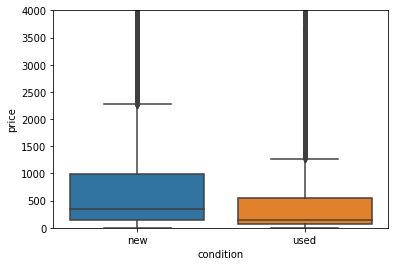

In [93]:
# New items tend to be more expensive
sns.boxplot(data = dfeats, x = "condition", y = "price")
plt.ylim(0, 4000)
plt.savefig(folder2save + "/Boxplot_price.png", dpi = 100, bbox_inches = "tight")        
#plt.close()


In [94]:

# Max price is very large, might be outlier
print(dfeats["price"].max())
print(dfeats["base_price"].max())


2222222222.0
2222222222.0


'\nPearson corr: There are some understandably high correlations, for instance, available_quantity and initial_quantity,\nor price and base_price. There are some interesting negative correlations, like currency_USD and accepts_mercadopago,\ndays since created or last updated and start_time\n\n'

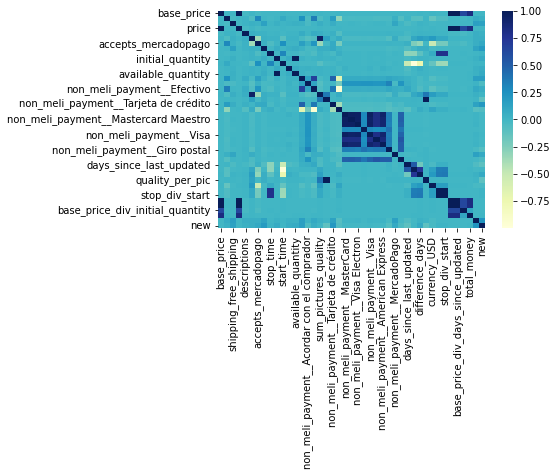

In [95]:

# Pearson's correlation
sns.heatmap(dfeats.corr(), cmap="YlGnBu")
plt.savefig(folder2save + "/Pearson_corr.png", dpi = 100, bbox_inches = "tight")        

"""
Pearson corr: There are some understandably high correlations, for instance, available_quantity and initial_quantity,
or price and base_price. There are some interesting negative correlations, like currency_USD and accepts_mercadopago,
days since created or last updated and start_time

"""


"\nCramer's V: The condition of the item is most strongly correlated with listing_type_id,\nfollowed by seller_frequency and buying mode. The other categories are not so strongly correlated\n"

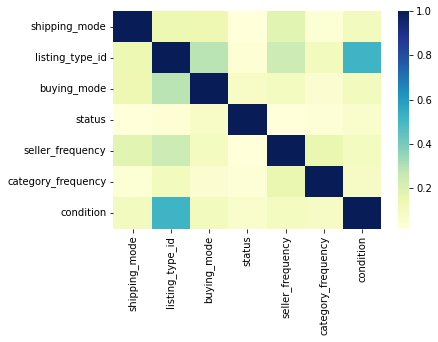

In [96]:

# Cramer's V coefficient 
# To understand the strength of the relationship between two categorical variables
dfeats = dfeats.apply(lambda x: x.astype("category") if x.dtype == "O" else x)

# Initialize a CamresV object using you pandas.DataFrame
dfeats.dtypes
cat_cols = ["shipping_mode", "listing_type_id","buying_mode","status","seller_frequency","category_frequency"
            ,"condition"]
cramersv = am.CramersV(dfeats[cat_cols])
dfcramer = cramersv.fit()
# will return a pairwise matrix filled with Cramer's V, where columns and index are 
# the categorical variables of the passed pandas.DataFrame
sns.heatmap(dfcramer, cmap="YlGnBu")
plt.savefig(folder2save + "/CramersV_corr.png", dpi = 100, bbox_inches = "tight")        
"""
Cramer's V: The condition of the item is most strongly correlated with listing_type_id,
followed by seller_frequency and buying mode. The other categories are not so strongly correlated
"""

Instead of deleting suspicious values, I won't assume they are outliers and that the data is clean. Now to the modeling section.

## Finding best model

In [97]:
#Set categorical features

dftrain= dftrain.apply(lambda x: x.astype("category") if x.dtype == "O" else x)
dftest = dftest.apply(lambda x: x.astype("category") if x.dtype == "O" else x)
categories = ['seller_address_state_name', 'seller_address_city_name', 'shipping_mode', 'listing_type_id',\
              'buying_mode', 'status','seller_frequency', 'category_frequency', 'garantia',"titulo"]

dftrain.drop(["condition"], axis = 1, inplace = True)
dftest.drop(["condition"], axis = 1, inplace = True)


In [98]:
#One Hot Encoding and normalizing

dftrain2 = dftrain.copy()
dftest2 = dftest.copy()

dic_ohes = {}
for cat in categories:
    print(cat)
    
    ohe_one = OneHotEncoder()
    A = pd.DataFrame(  ohe_one.fit_transform(dftrain[[cat]]).toarray(), columns = ohe_one.categories_[0] , index = dftrain.index)
    dftrain = dftrain.merge(A[ohe_one.categories_[0]], left_index = True, right_index = True)
    
    B = pd.DataFrame(  ohe_one.transform(dftest[[cat]]).toarray(), columns = ohe_one.categories_[0] , index = dftest.index)
    dftest = dftest.merge(B[ohe_one.categories_[0]], left_index = True, right_index = True)
    
    dic_ohes[cat] = ohe_one

dftrain.drop(categories, axis = 1, inplace = True)
dftest.drop(categories, axis = 1, inplace = True)

# Order
cols = dftrain.columns
dftest = dftest[cols]
cols2 = dftrain2.columns
dftest2 = dftest2[cols2]

# Scale
scale = StandardScaler()

Xtrain_scaled = scale.fit_transform(dftrain)
Xtest_scaled = scale.transform(dftest)



seller_address_state_name
seller_address_city_name
shipping_mode
listing_type_id
buying_mode
status
seller_frequency
category_frequency
garantia
titulo


### Baseline model

In [99]:
"""
Baseline
"""
from sklearn.dummy import DummyClassifier
clf_dum = DummyClassifier()
clf_dum.fit(Xtrain_scaled, y_train)
ypred = clf_dum.predict(Xtest_scaled)

acc_baseline = accuracy_score(y_test, ypred)
print("accuracy: " + str(accuracy_score(y_test, ypred)))


accuracy: 0.5406


As expected, in a baseline model the accuracy is simply the proportion of the classes

### Logistic Regression

In [100]:
"""
Let's start with something simple. A logistic regression with search of parameter C
"""
ytrain = [1 if y=="new" else 0 for y in y_train]
ytest = [1 if y=="new" else 0 for y in y_test]

from sklearn.linear_model import LogisticRegressionCV

clf_lr = LogisticRegressionCV(cv = 5, scoring = "accuracy", n_jobs=-1, random_state=2077)

clf_lr.fit(Xtrain_scaled, ytrain)

ypred = clf_lr.predict(Xtest_scaled)

print("Logistic Regression CV score")
print("accuracy: " + str(accuracy_score(ytest, ypred)))
print("roc_auc: " + str(roc_auc_score(ytest, ypred)))
print("confussion matrix: " + str( confusion_matrix(ytest, ypred) )    )
print(classification_report(ytest, ypred))


Logistic Regression CV score
accuracy: 0.8179
roc_auc: 0.8093430347389694
confussion matrix: [[3234 1360]
 [ 461 4945]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4594
           1       0.78      0.91      0.84      5406

    accuracy                           0.82     10000
   macro avg       0.83      0.81      0.81     10000
weighted avg       0.83      0.82      0.82     10000



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [101]:
df_logreg = pd.DataFrame({"acc":100 * np.round(accuracy_score(ytest, ypred),3),
                  "roc_auc": 100 * np.round(roc_auc_score(ytest, ypred),3),
                      }, index = ["log_reg"])
df_logreg

,acc,roc_auc
log_reg,81.8,80.9


### Random Forest

In [102]:
from sklearn.ensemble import RandomForestClassifier
    
clf_rf = RandomForestClassifier(random_state=2077, n_jobs=-1, class_weight = "balanced")


In [103]:
clf_rf.fit(Xtrain_scaled, ytrain)
ypred = clf_rf.predict(Xtest_scaled)

acc_rf = np.round(accuracy_score(ytest, ypred),2)
print("Random Forest score")
print("accuracy: " + str(100 * np.round(accuracy_score(ytest, ypred),3)  ))
print("roc_auc: " + str(100 * roc_auc_score(ytest, ypred)))
print("confussion_matrix: " + str( confusion_matrix(ytest, ypred) )    )
print(classification_report(ytest, ypred))


Random Forest score
accuracy: 88.2
roc_auc: 87.98767344560316
confussion_matrix: [[3939  655]
 [ 528 4878]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4594
           1       0.88      0.90      0.89      5406

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [104]:
df_rf = pd.DataFrame({"acc":100 * np.round(accuracy_score(ytest, ypred),3),
                  "roc_auc": 100 * np.round(roc_auc_score(ytest, ypred),3),
                      }, index = ["RF"])
df_rf

,acc,roc_auc
RF,88.2,88.0


In [105]:
""" feature importance RF """
feature_list = dftrain.columns
f_importance = list(clf_rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, f_importance)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
name = [x for x,y in feature_importances]
impo = [y for x,y in feature_importances]
pd.DataFrame({"feature":name, "importance":impo})[:20]


,feature,importance
0,available_quantity,0.10
1,free,0.10
2,initial_quantity,0.08
3,price,0.04
4,avg_picture_quality,0.04
5,quality_per_pic,0.04
6,base_price_div_initial_quantity,0.04
7,base_price,0.03
8,sold_quantity,0.03
9,sum_pictures_quality,0.03


The feature importance values show that price and quantity are important features, as well as some of the features engineered.

### Random Forest with Hyperparameter tuning

In [106]:
# Number of trees in random forest
n_estimators = [10, 20, 100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params = {
          'n_estimators': n_estimators,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap
          }


grid = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42, n_jobs=-1), 
                    param_distributions= params, 
                    n_iter=20,
                    scoring = "accuracy",
                    cv = 3, n_jobs = -1, verbose = 2, random_state=42)


grid.fit(Xtrain_scaled, ytrain)
print(grid.best_params_)
ypred = grid.predict(Xtest_scaled)

print("Grid Random Forest CV score")
print("accuracy: " + str(np.round(accuracy_score(ytest, ypred),3)  ))
print("roc_auc: " + str(roc_auc_score(ytest, ypred)))
print("confussion_matrix: " + str( confusion_matrix(ytest, ypred) )    )
print(classification_report(ytest, ypred))



Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}
Grid Random Forest CV score
accuracy: 0.882
roc_auc: 0.8793321034642655
confussion_matrix: [[3917  677]
 [ 508 4898]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4594
           1       0.88      0.91      0.89      5406

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [107]:
df_rf_grid = pd.DataFrame({"acc":100 * np.round(accuracy_score(ytest, ypred),3),
                  "roc_auc": 100 * np.round(roc_auc_score(ytest, ypred),3),
                      }, index = ["RF_grid"])
df_rf_grid

,acc,roc_auc
RF_grid,88.2,87.9


### Linear SVC
Since normal SVC is too slow for this amount of data

In [108]:
from sklearn.svm import LinearSVC

clf_svc = LinearSVC(random_state=2077, dual = False, class_weight = "balanced")

clf_svc.fit(Xtrain_scaled, ytrain)
ypred = clf_svc.predict(Xtest_scaled)

acc_svc = np.round(accuracy_score(ytest, ypred),2)
print("SVC score")
print("accuracy: " + str(np.round(accuracy_score(ytest, ypred),3)  ))
print("roc_auc: " + str(roc_auc_score(ytest, ypred)))
print("confussion_matrix: " + str( confusion_matrix(ytest, ypred) )    )
print(classification_report(ytest, ypred))


SVC score
accuracy: 0.811
roc_auc: 0.8030700743510291
confussion_matrix: [[3235 1359]
 [ 530 4876]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      4594
           1       0.78      0.90      0.84      5406

    accuracy                           0.81     10000
   macro avg       0.82      0.80      0.81     10000
weighted avg       0.82      0.81      0.81     10000



Liblinear failed to converge, increase the number of iterations.


In [109]:
df_svc = pd.DataFrame({"acc":100 * np.round(accuracy_score(ytest, ypred),3),
                  "roc_auc": 100 * np.round(roc_auc_score(ytest, ypred),3),
                      }, index = ["SVC"])
df_svc

,acc,roc_auc
SVC,81.1,80.3


### LIGHTGBM

In [127]:
dftrain3 = dftrain2.drop(["avg_picture_quality"], axis = 1).copy()
dftest3 = dftest2.drop(["avg_picture_quality"], axis = 1).copy()

import lightgbm as lgb
lgb_train = lgb.Dataset(dftrain3, label = ytrain)
lgb_eval = lgb.Dataset(dftest3, label = ytest, reference=lgb_train)

# specify your configurations as a dict
params = {
    'n_estimators':1000,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 100,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0,
    # 'class_weight': 'balanced',
    'random_state':42
}    
    

print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=100,
            valid_sets=lgb_eval ,  # eval training data
            feature_name=list(dftrain3.columns),
            #callbacks=[lgb.early_stopping(stopping_rounds=20)],
            categorical_feature=['seller_address_state_name', 'seller_address_city_name',
                    'shipping_mode', 'listing_type_id', 'buying_mode', 'status',
                    'seller_frequency', 'category_frequency', "garantia"]
            )    


ypred = gbm.predict(dftest3)
ypred = [1 if y>0.55 else 0 for y in ypred]


print("lightgbm score")
print("accuracy: " + str( np.round(accuracy_score(ytest, ypred),3)  ))
print("roc_auc: " + str( roc_auc_score(ytest, ypred)))
print("confussion_matrix: " + str( confusion_matrix(ytest, ypred) )    )
print(classification_report(ytest, ypred))



Starting training...


Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['buying_mode', 'category_frequency', 'garantia', 'listing_type_id', 'seller_address_city_name', 'seller_address_state_name', 'seller_frequency', 'shipping_mode', 'status']
categorical_feature in param dict is overridden.


[1]	valid_0's binary_logloss: 0.65536
[2]	valid_0's binary_logloss: 0.624935
[3]	valid_0's binary_logloss: 0.597769
[4]	valid_0's binary_logloss: 0.574188
[5]	valid_0's binary_logloss: 0.55193
[6]	valid_0's binary_logloss: 0.531702
[7]	valid_0's binary_logloss: 0.5166
[8]	valid_0's binary_logloss: 0.498709
[9]	valid_0's binary_logloss: 0.482859
[10]	valid_0's binary_logloss: 0.468237
[11]	valid_0's binary_logloss: 0.455206
[12]	valid_0's binary_logloss: 0.445694
[13]	valid_0's binary_logloss: 0.434719
[14]	valid_0's binary_logloss: 0.424671
[15]	valid_0's binary_logloss: 0.415216
[16]	valid_0's binary_logloss: 0.406621
[17]	valid_0's binary_logloss: 0.398819
[18]	valid_0's binary_logloss: 0.391282
[19]	valid_0's binary_logloss: 0.384344
[20]	valid_0's binary_logloss: 0.377717
[21]	valid_0's binary_logloss: 0.371487
[22]	valid_0's binary_logloss: 0.365828
[23]	valid_0's binary_logloss: 0.360056
[24]	valid_0's binary_logloss: 0.355158
[25]	valid_0's binary_logloss: 0.35051
[26]	valid_0's

In [128]:
df_lgb = pd.DataFrame({"acc":100 * np.round(accuracy_score(ytest, ypred),3),
              "roc_auc": 100 * np.round(roc_auc_score(ytest, ypred),3),
                  }, index = ["LGB"])
df_lgb

,acc,roc_auc
LGB,89.5,89.5


An accuray of 89.5%, the best of all models so far. Let's look at the feature importance:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

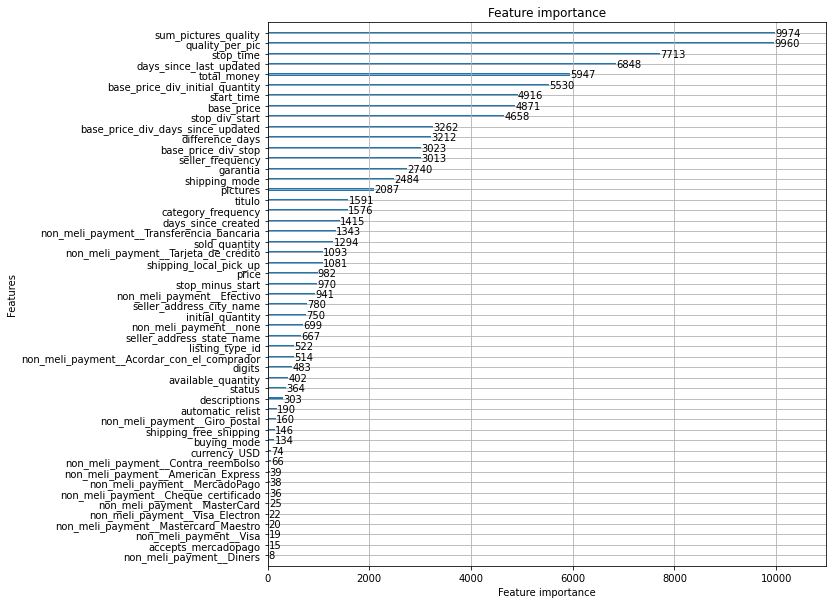

In [113]:
folder2save = os.path.join( os.getcwd(), "Plots")    
lgb.plot_importance(gbm, figsize=(10,10))


The feature importance plot shows that some of the engineered features are very useful. The price over the initial quantity, days since last updated, number of pictures, the features obtained from the pictures, seller frequency, including the categories built from the warranty ("garantia") and title ("titulo"). 

### XGBoost

In [114]:
"""XGB"""
from xgboost import XGBClassifier


bst = XGBClassifier(n_estimators=500, max_depth=50, learning_rate=0.05, objective='binary:logistic', n_jobs = -1, random_state=2077)

bst.fit(Xtrain_scaled, ytrain, eval_set = [(Xtest_scaled,ytest)] )

ypred = bst.predict(Xtest_scaled)

print("XGB score")
print("accuracy: " + str(np.round(accuracy_score(ytest, ypred),3)  ))
print("roc_auc: " + str(roc_auc_score(ytest, ypred)))
print("CM: " + str( confusion_matrix(ytest, ypred) )    )
print(classification_report(ytest, ypred))


[0]	validation_0-logloss:0.66293
[1]	validation_0-logloss:0.63552
[2]	validation_0-logloss:0.61070
[3]	validation_0-logloss:0.58803
[4]	validation_0-logloss:0.56748
[5]	validation_0-logloss:0.54839
[6]	validation_0-logloss:0.53085
[7]	validation_0-logloss:0.51440
[8]	validation_0-logloss:0.49908
[9]	validation_0-logloss:0.48526
[10]	validation_0-logloss:0.47250
[11]	validation_0-logloss:0.46069
[12]	validation_0-logloss:0.44954
[13]	validation_0-logloss:0.43912
[14]	validation_0-logloss:0.42937
[15]	validation_0-logloss:0.42037
[16]	validation_0-logloss:0.41207
[17]	validation_0-logloss:0.40432
[18]	validation_0-logloss:0.39700
[19]	validation_0-logloss:0.39034
[20]	validation_0-logloss:0.38388
[21]	validation_0-logloss:0.37778
[22]	validation_0-logloss:0.37189
[23]	validation_0-logloss:0.36656
[24]	validation_0-logloss:0.36137
[25]	validation_0-logloss:0.35651
[26]	validation_0-logloss:0.35196
[27]	validation_0-logloss:0.34789
[28]	validation_0-logloss:0.34408
[29]	validation_0-loglos

In [115]:
df_xgb = pd.DataFrame({"acc":100 * np.round(accuracy_score(ytest, ypred),3),
                  "roc_auc": 100 * np.round(roc_auc_score(ytest, ypred),3),
                      }, index = ["XGB"])
df_xgb

,acc,roc_auc
XGB,88.3,88.1


### Tensorflow
Let's test a dense network with dropout to prevent overfitting

In [116]:
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.clear_session()

model = keras.Sequential()

model.add( keras.layers.Input(shape = Xtrain_scaled.shape[1:]))
model.add( keras.layers.Dense(units = 80, activation = 'relu', kernel_initializer = 'he_normal'))
model.add( keras.layers.Dropout(0.1))
model.add( keras.layers.Dense(units = 60, activation = 'relu', kernel_initializer = 'he_normal'))
model.add( keras.layers.Dropout(0.1))
model.add( keras.layers.Dense(units = 30, activation = 'relu', kernel_initializer = 'he_normal'))
model.add( keras.layers.Dropout(0.1))
model.add( keras.layers.Dense(units = 10, activation = 'relu', kernel_initializer = 'he_normal'))
model.add( keras.layers.Dropout(0.1))
model.add( keras.layers.Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())    


early_stop = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(Xtrain_scaled, np.array(ytrain), 
                    batch_size=30, 
                    epochs=50, 
                    verbose=1, 
                    validation_split=0.2,
                    callbacks=[early_stop]
                    )


score = model.evaluate(Xtest_scaled, np.array(ytest), verbose=1)

ypred = model.predict(Xtest_scaled)
ypred = [1 if x[0]>0.5 else 0 for x in ypred]

accu_tf = np.round(accuracy_score(ytest, ypred))
print("TF score")
print("accuracy: " + str(np.round(accuracy_score(ytest, ypred),2)  ))
print("roc_auc: " + str(roc_auc_score(ytest, ypred)))
print("confussion_matrix: " + str( confusion_matrix(ytest, ypred) )    )
print(classification_report(ytest, ypred))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                7360      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                4860      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                3

In [119]:
ypred = model.predict(Xtest_scaled)
ypred = [1 if x[0]>0.55 else 0 for x in ypred]
df_tf = pd.DataFrame({"acc":100 * np.round(accuracy_score(ytest, ypred),3),
                  "roc_auc": 100 * np.round(roc_auc_score(ytest, ypred),3),
                      }, index = ["TF"])
df_tf

313/313 [==============================] - 1s 4ms/step


,acc,roc_auc
TF,84.6,84.4


### Model summary

LightGBM achieves the best accuracy and roc_auc values of 89.5%, followed closely by Random Forest and XGBoost.

In [118]:
pd.concat([df_logreg,df_rf,df_rf_grid,df_svc,df_lgb,df_xgb,df_tf])

,acc,roc_auc
log_reg,81.80,80.90
RF,88.20,88.00
RF_grid,88.20,87.90
SVC,81.10,80.30
LGB,89.50,89.50
XGB,88.30,88.10
TF,0.85,0.84


Besides of using the accuracy as a metric for measuring model performance, I've chosen the roc_auc value because it is a very useful metric for binary classification models. The roc_auc shows the balance between the True Positive Rate and False Positive Rate, or if one prefers, the sensitivity and specificity. It shows how good the model is discriminating between both classes. For unbalanced classification problems (not this case), the accuracy of a model can be misleading, and using other metrics becomes paramount.

## Model Explainability
SHAP is a very useful library for explaining a model.


In [120]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
import shap

In [131]:

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(dftest3)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


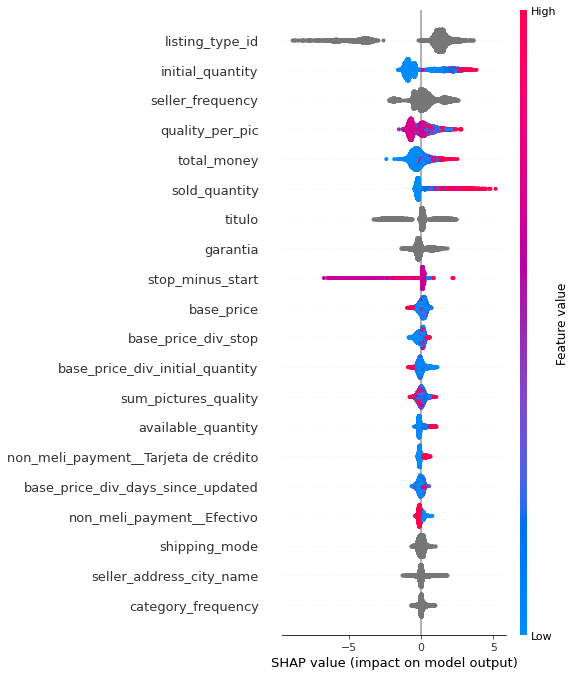

In [132]:
shap.summary_plot(shap_values[1], dftest3)

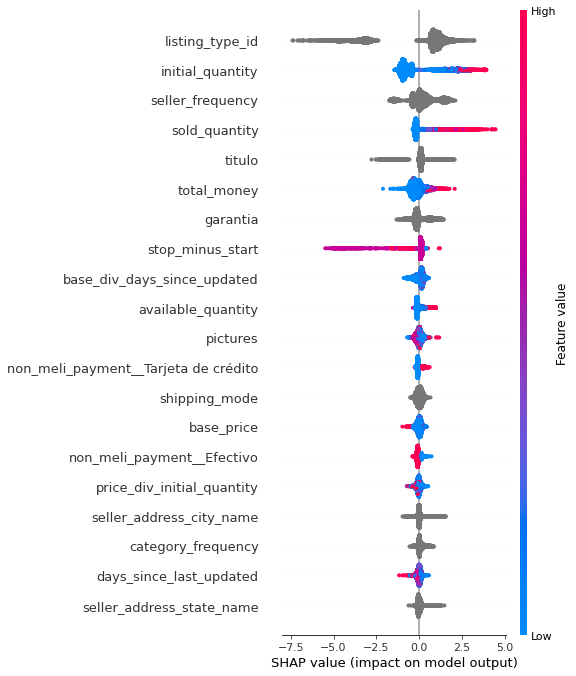

In [46]:
shap.summary_plot(shap_values[1], dftest2)

The SHAP summary plot shows that high values of initial and sold quantity, or paying with a credit card, they increase the probability of predicting "new", whereas high values of the difference between stop and start times and days since last updated decrease this probability (more likely to predict "used"). 

This plot also shows that the model uses the engineered features, like the ones built from warranty ("garantia"), title ("title), number of pictures, and seller frequency, to name a few. 

In [47]:
1+1

2